# Práctica 6: Support Vector Machines

---
### Autores: Grupo 7
Raúl Murillo Montero - 5º Doble Grado en Ingeniería Informática - Matemáticas   
Miguel Sierra Esteso - 4º Grado en Ingeniería Informática

---
**Fecha de entrega:** 13 de diciembre de 2018, 18.00h

In [166]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.optimize import minimize
from sklearn.svm import SVC
from process_email import email2TokenList
import codecs
from get_vocab_dict import getVocabDict
import glob

## 1. Support Vector Machines

In [196]:
def plot_decision_line(X, y, svm):
    svm.fit(X, y.ravel())
    x1 = np.linspace(X[:, 0].min(), X[:, 0].max(), 100)
    x2 = np.linspace(X[:, 1].min(), X[:, 1].max(), 100)
    x1, x2 = np.meshgrid(x1, x2)
    yp = svm.predict(np.array([x1.ravel(),x2.ravel()]).T).reshape(x1.shape)
    pos = (y == 1).ravel()
    neg = (y == 0).ravel()
    plt.figure()
    plt.scatter(X[pos, 0], X[pos, 1], color='black', marker='+')
    plt.scatter(X[neg, 0], X[neg, 1], color='yellow',
    edgecolors='black', marker='o')
    plt.contour(x1, x2, yp)

### 1.1 Kernel lineal

In [197]:
data = loadmat('ex6data1.mat')
X, y = data['X'], data['y'].ravel()

<IPython.core.display.Javascript object>


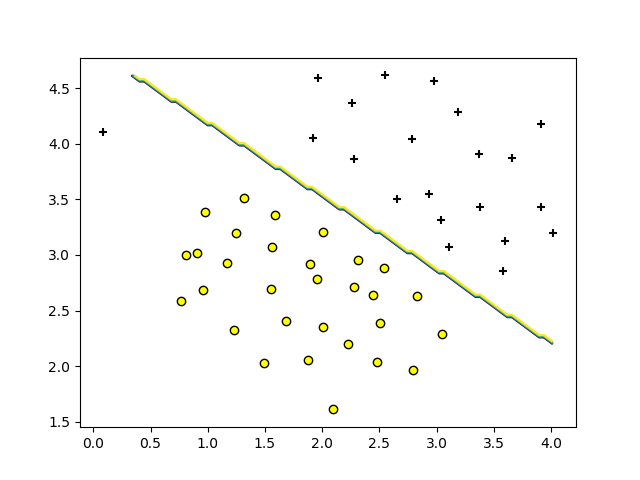

In [198]:
svm = SVC(kernel='linear', C=1)
plot_decision_line(X, y, svm)

<IPython.core.display.Javascript object>


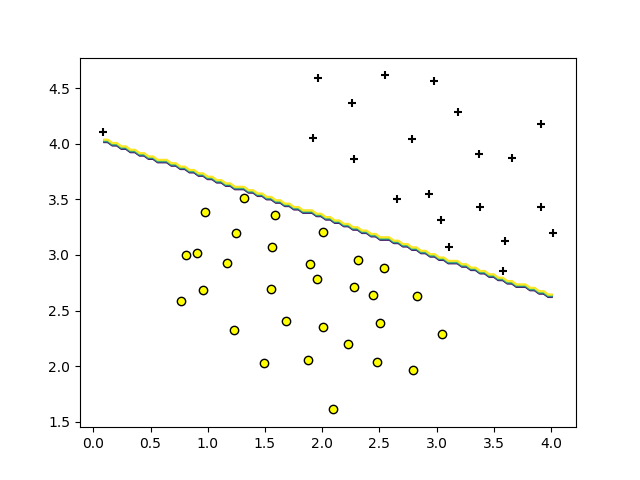

In [188]:
svm = SVC(kernel='linear', C=100)
plot_decision_line(X, y, svm)

### 1.2 Kernel gaussiano

In [199]:
data = loadmat('ex6data2.mat')
X, y = data['X'], data['y'].ravel()

<IPython.core.display.Javascript object>


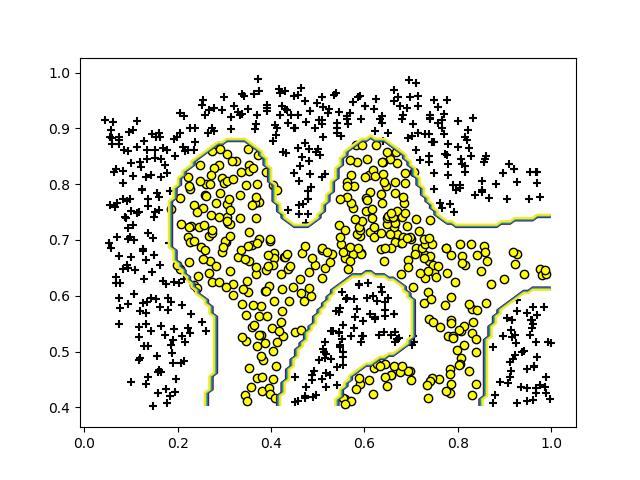

In [200]:
C = 1.0
sigma = 0.1

svm = SVC(kernel='rbf', C=C, gamma=1 / (2 * sigma**2))
svm.fit(X, y.ravel())
plot_decision_line(X, y, svm)

### 1.3 Elección de los parámetros $C$ y $\sigma$

In [201]:
data = loadmat('ex6data3.mat')
X, y, Xval, yval = data['X'], data['y'].ravel(), data['Xval'], data['yval'].ravel()

Error mínimo: 0.435
C óptimo: 4   sigma óptimo: 2


<IPython.core.display.Javascript object>


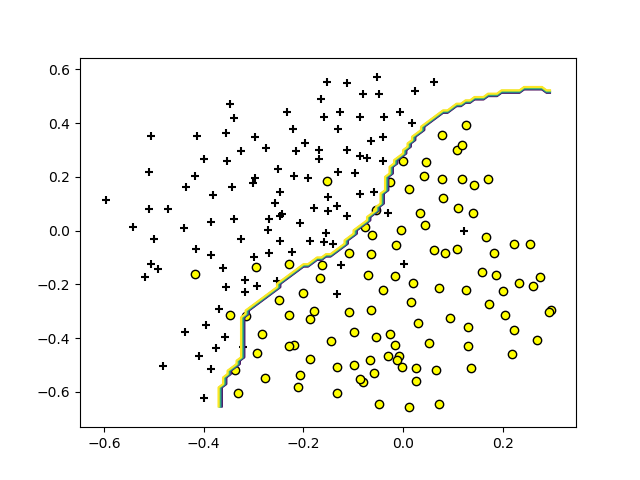

In [202]:
n = 8
errors = np.empty((n,n))

C = 0.01
for c in range(n):
    sigma = 0.01
    for s in range(n):
        svm = SVC(kernel='rbf', C=C, gamma=1 / (2 * sigma**2))
        svm.fit(X, y.ravel())
        errors[c,s] = svm.score(Xval,yval)
        sigma *= 3
    C *= 3

print('Error mínimo: {}'.format(errors.min()))
C_opt, sigma_opt = errors.argmax()//n, errors.argmax()%n
print('C óptimo: {}   sigma óptimo: {}'.format(C_opt, sigma_opt))

svm = SVC(kernel='rbf', C=0.01*3**C_opt, gamma=1 / (2 * (0.01*3**sigma_opt)**2))
plot_decision_line(X, y, svm)

## 2. Detección de spam

En primer lugar, procesar los correos electrónicos para generar los datos de entrenamiento
y validación.   
El siguiente paso es convertir el texto del mensaje en un vector de atributos.

In [164]:
corpus = getVocabDict()
# Process one mail
email_contents = codecs.open( 'spam/0001.txt', 'r', encoding='utf-8', errors='ignore').read()
tokens = email2TokenList(email_contents)
print(len(tokens))
email1 = np.zeros(len(corpus))
words = filter(None,[corpus.get(x) for x in tokens])
for i in words:
    email1[i-1] = 1
print(len(np.where(email1 == 1)[0]))

183
88


In [175]:
corpus = getVocabDict()
# Process all spam mails
files = glob.glob('spam/*.txt')
Xspam = np.zeros((len(files), len(corpus)))
yspam = np.ones(len(files))
i = 0
for f in files:
    email_contents = codecs.open(f, 'r', encoding='utf-8', errors='ignore').read()
    tokens = email2TokenList(email_contents)
    words = filter(None,[corpus.get(x) for x in tokens])
    for w in words:
        Xspam[i, w-1] = 1
    i +=1
# Process all easy_ham mails
files = glob.glob('easy_ham/*.txt')
Xeasy_ham = np.zeros((len(files), len(corpus)))
yeasy_ham = np.zeros(len(files))
i = 0
for f in files:
    email_contents = codecs.open(f, 'r', encoding='utf-8', errors='ignore').read()
    tokens = email2TokenList(email_contents)
    words = filter(None,[corpus.get(x) for x in tokens])
    for w in words:
        Xeasy_ham[i, w-1] = 1
    i +=1
# Process all hard_ham mails
files = glob.glob('hard_ham/*.txt')
Xhard_ham = np.zeros((len(files), len(corpus)))
yhard_ham = np.zeros(len(files))
i = 0
for f in files:
    email_contents = codecs.open(f, 'r', encoding='utf-8', errors='ignore').read()
    tokens = email2TokenList(email_contents)
    words = filter(None,[corpus.get(x) for x in tokens])
    for w in words:
        Xhard_ham[i, w-1] = 1
    i +=1

In [176]:
Xspam.shape, Xeasy_ham.shape, Xhard_ham.shape

((500, 1899), (2551, 1899), (250, 1899))

Una vez hemos obtenido el dataset, debemos generar los datos de entrenamiento
y validación, esto es, se deben evaluar distintas configuraciones del sistema de aprendizaje.